**MOBILENETV2 TRAINING**

In [ ]:
# 1. Menginstal library Kaggle
!pip install -q kaggle

# 2. Mengimpor library untuk upload file
from google.colab import files

# 3. Menampilkan tombol upload untuk file kaggle.json
# Saat diminta, silakan pilih file 'kaggle.json' yang Anda download tadi
print("Mohon unggah file kaggle.json Anda:")
files.upload()

# 4. Membuat direktori .kaggle dan memindahkan file token
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# 5. Mengubah izin file (wajib oleh Kaggle)
!chmod 600 ~/.kaggle/kaggle.json

# 6. Mendownload dataset (ini mungkin perlu 1-2 menit)
# Nama dataset: 'paultimothymooney/chest-xray-pneumonia'
print("\nDownloading dataset...")
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# 7. Unzip dataset
# Flag '-q' berarti 'quiet' (tidak menampilkan semua nama file)
print("Unzipping dataset...")
!unzip -q chest-xray-pneumonia.zip

# 8. Verifikasi hasil unzip
# Kita cek isi dari direktori utama dataset
print("\nIsi dari direktori 'chest_xray':")
!ls -l chest_xray/

# 9. (Opsional tapi direkomendasikan) Hapus file zip agar tidak memakan tempat
!rm chest-xray-pneumonia.zip

Mohon unggah file kaggle.json Anda:


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 98% 2.25G/2.29G [00:16<00:00, 232MB/s]
100% 2.29G/2.29G [00:16<00:00, 146MB/s]
Unzipping dataset...

Isi dari direktori 'chest_xray':
total 20
drwxr-xr-x 5 root root 4096 Oct 20 06:24 chest_xray
drwxr-xr-x 3 root root 4096 Oct 20 06:24 __MACOSX
drwxr-xr-x 4 root root 4096 Oct 20 06:24 test
drwxr-xr-x 4 root root 4096 Oct 20 06:24 train
drwxr-xr-x 4 root root 4096 Oct 20 06:24 val


Path direktori Latih (train) yang digunakan: /content/chest_xray/train
Isi direktori Latih (train): ['PNEUMONIA', 'NORMAL']
Isi direktori Validasi (val): ['PNEUMONIA', 'NORMAL']
Isi direktori Uji (test): ['PNEUMONIA', 'NORMAL']
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

Label mapping (Penting untuk diingat):
{'NORMAL': 0, 'PNEUMONIA': 1}


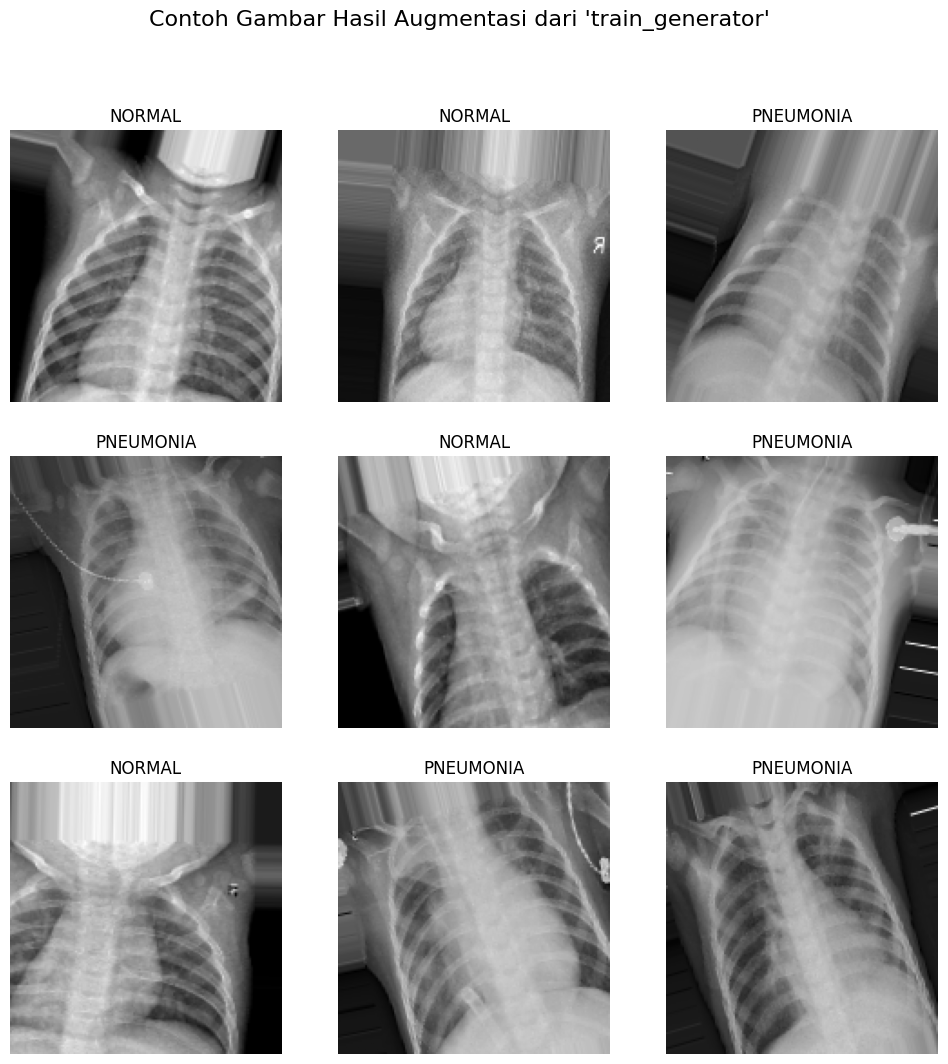

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os # Untuk menggabungkan path

# 1. Menentukan parameter dasar
IMG_SIZE = (150, 150) # Kita akan resize semua gambar ke 150x150
BATCH_SIZE = 32      # Model akan dilatih dalam batch berisi 32 gambar

# 2. Menentukan path direktori (INI BAGIAN YANG DIPERBAIKI)
# Path dasar sekarang adalah '/content/chest_xray/'
base_dir = '/content/chest_xray/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# 3. Verifikasi cepat isi direktori (Sekarang seharusnya berhasil)
print(f"Path direktori Latih (train) yang digunakan: {train_dir}")
print(f"Isi direktori Latih (train): {os.listdir(train_dir)}")
print(f"Isi direktori Validasi (val): {os.listdir(val_dir)}")
print(f"Isi direktori Uji (test): {os.listdir(test_dir)}")

# 4. Membuat Data Generator
# Generator untuk data latih (dengan augmentasi)
train_datagen = ImageDataGenerator(
    rescale=1./255,            # Normalisasi piksel dari 0-255 ke 0-1
    rotation_range=20,         # Rotasi gambar secara acak
    width_shift_range=0.2,     # Geser lebar gambar
    height_shift_range=0.2,    # Geser tinggi gambar
    shear_range=0.2,           # Miringkan gambar
    zoom_range=0.2,            # Zoom gambar
    horizontal_flip=True,      # Balik gambar secara horizontal
    fill_mode='nearest'        # Isi piksel yang hilang dengan piksel terdekat
)

# Generator untuk data validasi dan uji (hanya rescale)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# 5. Membuat 'Iterator' atau 'Flow' dari direktori
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',   # Karena kita punya 2 kelas: NORMAL vs PNEUMONIA
    color_mode='rgb'       # Kita set ke RGB agar kompatibel dengan model pre-trained
)

validation_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False          # Tidak perlu di-shuffle untuk validasi
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False          # Tidak perlu di-shuffle untuk pengujian
)

# 6. Verifikasi & Visualisasi
# Dapatkan satu batch gambar
images, labels = next(train_generator)

# Cek label
print("\nLabel mapping (Penting untuk diingat):")
print(train_generator.class_indices)

# Visualisasi beberapa gambar dari batch
plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    # Beri judul 'PNEUMONIA' atau 'NORMAL'
    if labels[i] == 0:
        plt.title("NORMAL")
    else:
        plt.title("PNEUMONIA")

    plt.axis("off")

plt.suptitle("Contoh Gambar Hasil Augmentasi dari 'train_generator'", fontsize=16)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# 1. Parameter dasar (masih sama)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# 2. Path direktori (KITA AKAN ABAIKAN val_dir)
base_dir = '/content/chest_xray/'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
# Kita tidak akan menggunakan path '/content/chest_xray/val/' lagi

print(f"Path direktori Latih (train) yang digunakan: {train_dir}")
print(f"Path direktori Uji (test) yang digunakan: {test_dir}")

# 3. Membuat Data Generator
# Generator data latih (DENGAN augmentasi DAN validation_split)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # <-- INI KUNCINYA: 20% dari data latih akan jadi data validasi
)

# Generator data uji (TANPA augmentasi, TANPA split)
# Ini digunakan untuk data 'test' yang sesungguhnya
test_datagen = ImageDataGenerator(rescale=1./255)

# 4. Membuat 'Iterator' dari direktori
print("\n--- MEMBUAT DATA GENERATOR BARU ---")

# Iterator Latih (80% dari data 'train_dir')
train_generator_new = train_datagen.flow_from_directory(
    train_dir,                 # Path ke data latih
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='training'          # <-- Tentukan ini sebagai set 'training'
)

# Iterator Validasi (20% dari data 'train_dir')
validation_generator_new = train_datagen.flow_from_directory(
    train_dir,                 # Path yang sama dengan data latih
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    subset='validation',       # <-- Tentukan ini sebagai set 'validation'
    shuffle=False              # Tidak perlu di-shuffle untuk validasi
)

# Iterator Uji (100% dari data 'test_dir')
test_generator_new = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# 5. Verifikasi output
print("\n--- VERIFIKASI GENERATOR BARU ---")
print("Label mapping (seharusnya tetap sama):")
print(train_generator_new.class_indices)

Path direktori Latih (train) yang digunakan: /content/chest_xray/train
Path direktori Uji (test) yang digunakan: /content/chest_xray/test

--- MEMBUAT DATA GENERATOR BARU ---
Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.

--- VERIFIKASI GENERATOR BARU ---
Label mapping (seharusnya tetap sama):
{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Definisikan ulang parameter input (untuk keamanan)
IMG_SHAPE = (150, 150, 3)

# 2. Muat Base Model (MobileNetV2)
# Kita memuat arsitektur MobileNetV2 yang sudah dilatih di ImageNet
# include_top=False berarti kita TIDAK menyertakan lapisan classifier terakhirnya
base_model_mobilenet = MobileNetV2(input_shape=IMG_SHAPE,
                                   include_top=False,
                                   weights='imagenet')

# 3. Bekukan Base Model
# Kita "membekukan" semua lapisan di MobileNetV2
# Ini berarti bobot (weights) mereka tidak akan berubah selama pelatihan
base_model_mobilenet.trainable = False

# 4. Bangun Arsitektur Model (Classifier Head)
# Kita akan menggunakan Keras Functional API
inputs = Input(shape=IMG_SHAPE)

# Jalankan input melalui base model (yang sudah beku)
x = base_model_mobilenet(inputs, training=False)

# Tambahkan lapisan 'pooling' untuk merangkum fitur
x = GlobalAveragePooling2D()(x)

# Tambahkan dropout untuk regularisasi (mencegah overfitting)
x = Dropout(0.2)(x)

# Tambahkan lapisan output akhir
# Kita gunakan 1 neuron dengan aktivasi 'sigmoid' untuk klasifikasi biner
outputs = Dense(1, activation='sigmoid')(x)

# Gabungkan menjadi model akhir
model_mobilenet = Model(inputs, outputs)

# 5. Compile Model
# Kita akan menggunakan Adam optimizer dengan learning rate yang kecil
# Ini penting untuk transfer learning agar tidak "merusak" bobot yang sudah ada
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy',
                                 tf.keras.metrics.Precision(name='precision'),
                                 tf.keras.metrics.Recall(name='recall')])

# 6. Tampilkan Ringkasan Model
# Perhatikan jumlah 'Trainable params' (seharusnya sangat kecil)
print("--- RINGKASAN MODEL MOBILENETV2 ---")
model_mobilenet.summary()

# 7. Siapkan Callback (Early Stopping)
# Ini akan menghentikan pelatihan jika 'val_loss' tidak membaik
# selama 3 epoch berturut-turut (patience=3)
early_stop = EarlyStopping(monitor='val_loss', patience=3,
                           restore_best_weights=True)

# 8. Mulai Pelatihan Model!
# Kita akan melatih selama 20 epoch, tapi EarlyStopping mungkin
# akan menghentikannya lebih awal.
EPOCHS = 20

print("\n--- MEMULAI PELATIHAN MODEL MOBILENETV2 ---")

# Gunakan generator baru yang sudah kita buat
history_mobilenet = model_mobilenet.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop]
)

print("\n--- PELATIHAN MODEL MOBILENETV2 SELESAI ---")

/tmp/ipython-input-2125068113.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(input_shape=IMG_SHAPE,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- RINGKASAN MODEL MOBILENETV2 ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- MEMULAI PELATIHAN MODEL MOBILENETV2 ---


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 108s 696ms/step - accuracy: 0.5746 - loss: 0.7390 - precision: 0.7319 - recall: 0.6694 - val_accuracy: 0.7526 - val_loss: 0.5312 - val_precision: 0.7547 - val_recall: 0.9884
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 505ms/step - accuracy: 0.7439 - loss: 0.5401 - precision: 0.7705 - recall: 0.9322 - val_accuracy: 0.7891 - val_loss: 0.4327 - val_precision: 0.8026 - val_recall: 0.9497
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 503ms/step - accuracy: 0.7854 - loss: 0.4570 - precision: 0.8102 - recall: 0.9295 - val_accuracy: 0.8380 - val_loss: 0.3671 - val_precision: 0.8435 - val_recall: 0.9600
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.8194 - loss: 0.3954 - precision: 0.8386 - recall: 0.9381 - val_accuracy: 0.8418 - val_loss: 0.3403 - val_precision: 0.8605 - val_recall: 0.9394
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 501ms/step - accuracy: 0.8349 - loss: 0.3591 - precision: 0.8519 - recall: 0.9400 - val_accuracy: 0.842

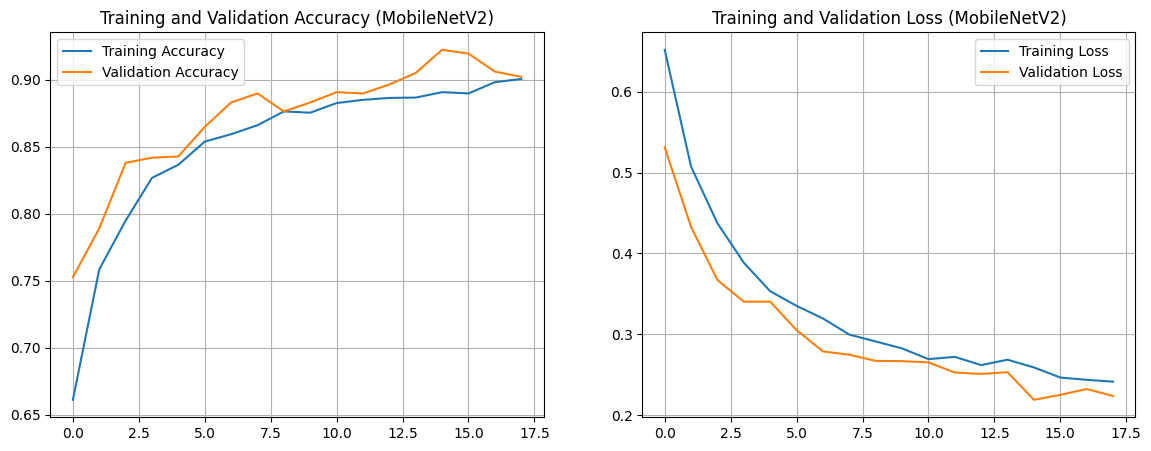


--- MENGEVALUASI MODEL MOBILENETV2 PADA TEST SET ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 693ms/step - accuracy: 0.7979 - loss: 0.4363 - precision: 0.4609 - recall: 0.6071



Test Loss:     0.3518
Test Accuracy: 0.8446 (84.46%)
Test Precision: 0.8447 (84.47%)
Test Recall:   0.9205 (92.05%)

--- MODEL MOBILENETV2 BERHASIL DISIMPAN SEBAGAI 'mobilenetv2_model.h5' ---
-rw-r--r-- 1 root root 9.0M Oct 20 06:54 mobilenetv2_model.h5


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualisasi Kurva Akurasi dan Loss
# Kita akan ambil data dari objek 'history_mobilenet'
acc = history_mobilenet.history['accuracy']
val_acc = history_mobilenet.history['val_accuracy']
loss = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

# Hitung jumlah epoch yang sebenarnya berjalan
# (jika berhenti lebih awal, ukurannya akan < 20)
epochs_ran = range(len(acc))

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, label='Training Accuracy')
plt.plot(epochs_ran, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, label='Training Loss')
plt.plot(epochs_ran, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.legend()
plt.grid(True)

plt.show()

# 2. Evaluasi Model pada Test Set
# Ini adalah metrik performa 'resmi' untuk paper Anda
print("\n--- MENGEVALUASI MODEL MOBILENETV2 PADA TEST SET ---")

# Gunakan 'test_generator_new'
# Outputnya adalah: [loss, accuracy, precision, recall]
test_metrics_mobilenet = model_mobilenet.evaluate(test_generator_new, verbose=1)

print(f"\nTest Loss:     {test_metrics_mobilenet[0]:.4f}")
print(f"Test Accuracy: {test_metrics_mobilenet[1]:.4f} ({(test_metrics_mobilenet[1]*100):.2f}%)")
print(f"Test Precision: {test_metrics_mobilenet[2]:.4f} ({(test_metrics_mobilenet[2]*100):.2f}%)")
print(f"Test Recall:   {test_metrics_mobilenet[3]:.4f} ({(test_metrics_mobilenet[3]*100):.2f}%)")

# 3. Menyimpan Model
# Kita simpan model terbaik (dari Epoch 15) ke file
model_mobilenet.save('mobilenetv2_model.h5')

print("\n--- MODEL MOBILENETV2 BERHASIL DISIMPAN SEBAGAI 'mobilenetv2_model.h5' ---")

# (Opsional) Verifikasi file sudah tersimpan
!ls -lh mobilenetv2_model.h5

**EFFICIENTNETB0 TRAINING**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0  # <-- Kita ganti model di sini
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Definisikan ulang parameter input (masih sama)
IMG_SHAPE = (150, 150, 3)

# 2. Muat Base Model (EfficientNetB0)
base_model_efficientnet = EfficientNetB0(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')

# 3. Bekukan Base Model
base_model_efficientnet.trainable = False

# 4. Bangun Arsitektur Model (Classifier Head)
# Strukturnya sama persis dengan sebelumnya
inputs = Input(shape=IMG_SHAPE)
x = base_model_efficientnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_efficientnet = Model(inputs, outputs)

# 5. Compile Model
# Optimizer dan metrics sama persis
model_efficientnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                           loss='binary_crossentropy',
                           metrics=['accuracy',
                                    tf.keras.metrics.Precision(name='precision'),
                                    tf.keras.metrics.Recall(name='recall')])

# 6. Tampilkan Ringkasan Model
print("--- RINGKASAN MODEL EFFICIENTNETB0 ---")
model_efficientnet.summary()

# 7. Siapkan Callback (Early Stopping)
# Kita buat ulang objek callback-nya
early_stop_effnet = EarlyStopping(monitor='val_loss', patience=3,
                                  restore_best_weights=True)

# 8. Mulai Pelatihan Model!
EPOCHS = 20 # Tetap gunakan 20 sebagai batas maksimum

print("\n--- MEMULAI PELATIHAN MODEL EFFICIENTNETB0 ---")

# Pastikan menggunakan generator yang benar (yang baru)
history_efficientnet = model_efficientnet.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop_effnet] # Gunakan callback baru
)

print("\n--- PELATIHAN MODEL EFFICIENTNETB0 SELESAI ---")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- RINGKASAN MODEL EFFICIENTNETB0 ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- MEMULAI PELATIHAN MODEL EFFICIENTNETB0 ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 119s 727ms/step - accuracy: 0.4735 - loss: 0.7205 - precision: 0.7066 - recall: 0.4525 - val_accuracy: 0.7430 - val_loss: 0.5724 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 504ms/step - accuracy: 0.7504 - loss: 0.5642 - precision: 0.7504 - recall: 1.0000 - val_accuracy: 0.7430 - val_loss: 0.5699 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 508ms/step - accuracy: 0.7399 - loss: 0.5740 - precision: 0.7399 - recall: 1.0000 - val_accuracy: 0.7430 - val_loss: 0.5697 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.7393 - loss: 0.5747 - precision: 0.7393 - recall: 1.0000 - val_accuracy: 0.7430 - val_loss: 0.5697 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 508ms/step - accuracy: 0.7453 - loss: 0.5685 - precisio

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# --- TAHAP 6 (PERBAIKAN: Menambahkan Class Weights) ---

# 1. Menghitung Class Weights
# Kita perlu tahu jumlah pasti setiap kelas di 'train_dir'
# (Kita tahu dari Tahap 3: 4173 total, 1043 validasi = 5216 total di dir)
# Jumlah total di direktori train:
# PNEUMONIA: 3875
# NORMAL: 1341
# Total: 5216

total_train_images = 5216
count_normal = 1341
count_pneumonia = 3875

# Rumus kalkulasi bobot
weight_for_0 = (1 / count_normal) * (total_train_images / 2.0)
weight_for_1 = (1 / count_pneumonia) * (total_train_images / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print("--- MENGGUNAKAN CLASS WEIGHTS UNTUK MENGATASI IMBALANCE ---")
print(f"Bobot untuk NORMAL (0): {weight_for_0:.2f}")
print(f"Bobot untuk PNEUMONIA (1): {weight_for_1:.2f}")
print("Ini akan 'menghukum' model lebih berat jika salah menebak NORMAL.")

# 2. Definisikan ulang parameter input (masih sama)
IMG_SHAPE = (150, 150, 3)

# 3. Muat Base Model (EfficientNetB0)
# Kita buat ulang dari awal
base_model_efficientnet_weighted = EfficientNetB0(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

# 4. Bekukan Base Model
base_model_efficientnet_weighted.trainable = False

# 5. Bangun Arsitektur Model (Classifier Head)
inputs = Input(shape=IMG_SHAPE)
x = base_model_efficientnet_weighted(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_efficientnet_weighted = Model(inputs, outputs)

# 6. Compile Model
model_efficientnet_weighted.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                    loss='binary_crossentropy',
                                    metrics=['accuracy',
                                             tf.keras.metrics.Precision(name='precision'),
                                             tf.keras.metrics.Recall(name='recall')])

# 7. Tampilkan Ringkasan Model
print("\n--- RINGKASAN MODEL EFFICIENTNETB0 (WEIGHTED) ---")
model_efficientnet_weighted.summary()

# 8. Siapkan Callback
early_stop_effnet_weighted = EarlyStopping(monitor='val_loss', patience=3,
                                           restore_best_weights=True)

# 9. Mulai Pelatihan Model (DENGAN CLASS WEIGHTS)
EPOCHS = 20

print("\n--- MEMULAI PELATIHAN MODEL EFFICIENTNETB0 (WEIGHTED) ---")

history_efficientnet_weighted = model_efficientnet_weighted.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop_effnet_weighted],
    class_weight=class_weights  # <-- INI ADALAH KUNCI PERBAIKANNYA
)

print("\n--- PELATIHAN MODEL EFFICIENTNETB0 (WEIGHTED) SELESAI ---")

--- MENGGUNAKAN CLASS WEIGHTS UNTUK MENGATASI IMBALANCE ---
Bobot untuk NORMAL (0): 1.94
Bobot untuk PNEUMONIA (1): 0.67
Ini akan 'menghukum' model lebih berat jika salah menebak NORMAL.

--- RINGKASAN MODEL EFFICIENTNETB0 (WEIGHTED) ---


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- MEMULAI PELATIHAN MODEL EFFICIENTNETB0 (WEIGHTED) ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 127s 823ms/step - accuracy: 0.5741 - loss: 0.6896 - precision: 0.7515 - recall: 0.6457 - val_accuracy: 0.7430 - val_loss: 0.6857 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 513ms/step - accuracy: 0.5370 - loss: 0.6990 - precision: 0.7399 - recall: 0.5774 - val_accuracy: 0.6510 - val_loss: 0.6929 - val_precision: 0.7212 - val_recall: 0.8645
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 505ms/step - accuracy: 0.4921 - loss: 0.6995 - precision: 0.7387 - recall: 0.4849 - val_accuracy: 0.2570 - val_loss: 0.6978 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 505ms/step - accuracy: 0.4894 - loss: 0.6979 - precision: 0.7522 - recall: 0.4617 - val_accuracy: 0.2570 - val_loss: 0.7005 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00

--- PELATIHAN MODEL EFFICIENTNETB0 (WEIGHTED) SELESAI ---


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# --- TAHAP 6 (PERBAIKAN 2: Menurunkan Learning Rate) ---

# 1. Class Weights (Masih kita perlukan)
total_train_images = 5216
count_normal = 1341
count_pneumonia = 3875
weight_for_0 = (1 / count_normal) * (total_train_images / 2.0)
weight_for_1 = (1 / count_pneumonia) * (total_train_images / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

print("--- MENGGUNAKAN CLASS WEIGHTS DAN LEARNING RATE RENDAH ---")
print(f"Bobot untuk NORMAL (0): {weight_for_0:.2f}")
print(f"Bobot untuk PNEUMONIA (1): {weight_for_1:.2f}")


# 2. Definisikan ulang parameter input
IMG_SHAPE = (150, 150, 3)

# 3. Muat Base Model (EfficientNetB0)
base_model_efficientnet_final = EfficientNetB0(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

# 4. Bekukan Base Model
base_model_efficientnet_final.trainable = False

# 5. Bangun Arsitektur Model (Classifier Head)
inputs = Input(shape=IMG_SHAPE)
x = base_model_efficientnet_final(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_efficientnet_final = Model(inputs, outputs)

# 6. Compile Model (DENGAN PERUBAHAN)
# KITA UBAH 'learning_rate' DARI 0.0001 MENJADI 0.00001 (1e-5)
model_efficientnet_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                                 loss='binary_crossentropy',
                                 metrics=['accuracy',
                                          tf.keras.metrics.Precision(name='precision'),
                                          tf.keras.metrics.Recall(name='recall')])

# 7. Tampilkan Ringkasan Model
print("\n--- RINGKASAN MODEL EFFICIENTNETB0 (Final Attempt) ---")
model_efficientnet_final.summary()

# 8. Siapkan Callback
# Kita tingkatkan patience menjadi 5, karena learning rate-nya lambat
early_stop_effnet_final = EarlyStopping(monitor='val_loss', patience=5,
                                        restore_best_weights=True)

# 9. Mulai Pelatihan Model
EPOCHS = 20 # Tetap 20, tapi mungkin akan berjalan lebih lama

print("\n--- MEMULAI PELATIHAN EFFICIENTNETB0 (LR RENDAH + WEIGHTED) ---")

history_efficientnet_final = model_efficientnet_final.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop_effnet_final],
    class_weight=class_weights
)

print("\n--- PELATIHAN MODEL EFFICIENTNETB0 (Final Attempt) SELESAI ---")

--- MENGGUNAKAN CLASS WEIGHTS DAN LEARNING RATE RENDAH ---
Bobot untuk NORMAL (0): 1.94
Bobot untuk PNEUMONIA (1): 0.67

--- RINGKASAN MODEL EFFICIENTNETB0 (Final Attempt) ---


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- MEMULAI PELATIHAN EFFICIENTNETB0 (LR RENDAH + WEIGHTED) ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 107s 671ms/step - accuracy: 0.5098 - loss: 0.6826 - precision: 0.7588 - recall: 0.5189 - val_accuracy: 0.7430 - val_loss: 0.6902 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.4942 - loss: 0.7020 - precision: 0.7363 - recall: 0.4887 - val_accuracy: 0.7430 - val_loss: 0.6909 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.5072 - loss: 0.6965 - precision: 0.7409 - recall: 0.5161 - val_accuracy: 0.7430 - val_loss: 0.6905 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 67s 511ms/step - accuracy: 0.5069 - loss: 0.6951 - precision: 0.7472 - recall: 0.5091 - val_accuracy: 0.7430 - val_loss: 0.6900 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 66s 502ms/step - accuracy: 0.5103 - loss: 

**RESTNET50 TRAINING**

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50  # <-- Kita ganti model di sini
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# 1. Definisikan ulang parameter input
IMG_SHAPE = (150, 150, 3)

# 2. Muat Base Model (ResNet50)
base_model_resnet = ResNet50(input_shape=IMG_SHAPE,
                             include_top=False,
                             weights='imagenet')

# 3. Bekukan Base Model
base_model_resnet.trainable = False

# 4. Bangun Arsitektur Model (Classifier Head)
# Strukturnya sama persis
inputs = Input(shape=IMG_SHAPE)
x = base_model_resnet(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs, outputs)

# 5. Compile Model
# Kita gunakan setup awal yang sukses (LR 1e-4, tanpa class_weight)
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     loss='binary_crossentropy',
                     metrics=['accuracy',
                              tf.keras.metrics.Precision(name='precision'),
                              tf.keras.metrics.Recall(name='recall')])

# 6. Tampilkan Ringkasan Model
# Perhatikan jumlah Non-trainable params. Akan jauh lebih besar.
print("--- RINGKASAN MODEL RESNET50 (Baseline Berat) ---")
model_resnet.summary()

# 7. Siapkan Callback
# Kita set patience=5 untuk model besar ini
early_stop_resnet = EarlyStopping(monitor='val_loss', patience=5,
                                  restore_best_weights=True)

# 8. Mulai Pelatihan Model!
EPOCHS = 20

print("\n--- MEMULAI PELATIHAN MODEL RESNET50 ---")

# Gunakan generator yang sama
history_resnet = model_resnet.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop_resnet]
)

print("\n--- PELATIHAN MODEL RESNET50 SELESAI ---")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- RINGKASAN MODEL RESNET50 (Baseline Berat) ---


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- MEMULAI PELATIHAN MODEL RESNET50 ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 93s 621ms/step - accuracy: 0.3345 - loss: 0.8817 - precision: 0.7263 - recall: 0.1603 - val_accuracy: 0.7430 - val_loss: 0.6181 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 527ms/step - accuracy: 0.6815 - loss: 0.6187 - precision: 0.7387 - recall: 0.8836 - val_accuracy: 0.7430 - val_loss: 0.5750 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 531ms/step - accuracy: 0.7338 - loss: 0.5958 - precision: 0.7376 - recall: 0.9911 - val_accuracy: 0.7430 - val_loss: 0.5724 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 522ms/step - accuracy: 0.7370 - loss: 0.5890 - precision: 0.7378 - recall: 0.9985 - val_accuracy: 0.7430 - val_loss: 0.5707 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 528ms/step - accuracy: 0.7340 - loss: 0.5912 - precision: 0.73

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# --- TAHAP 8 (PERBAIKAN: Menambahkan Class Weights ke ResNet50) ---

# 1. Class Weights (Masih kita perlukan)
total_train_images = 5216
count_normal = 1341
count_pneumonia = 3875
weight_for_0 = (1 / count_normal) * (total_train_images / 2.0)
weight_for_1 = (1 / count_pneumonia) * (total_train_images / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

print("--- MENGGUNAKAN CLASS WEIGHTS UNTUK RESNET50 ---")
print(f"Bobot untuk NORMAL (0): {weight_for_0:.2f}")
print(f"Bobot untuk PNEUMONIA (1): {weight_for_1:.2f}")

# 2. Definisikan ulang parameter input
IMG_SHAPE = (150, 150, 3)

# 3. Muat Base Model (ResNet50)
base_model_resnet_weighted = ResNet50(input_shape=IMG_SHAPE,
                                      include_top=False,
                                      weights='imagenet')

# 4. Bekukan Base Model
base_model_resnet_weighted.trainable = False

# 5. Bangun Arsitektur Model (Classifier Head)
inputs = Input(shape=IMG_SHAPE)
x = base_model_resnet_weighted(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_resnet_weighted = Model(inputs, outputs)

# 6. Compile Model
# Kita gunakan LR 1e-4
model_resnet_weighted.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                              loss='binary_crossentropy',
                              metrics=['accuracy',
                                       tf.keras.metrics.Precision(name='precision'),
                                       tf.keras.metrics.Recall(name='recall')])

# 7. Tampilkan Ringkasan Model
print("\n--- RINGKASAN MODEL RESNET50 (WEIGHTED) ---")
model_resnet_weighted.summary()

# 8. Siapkan Callback
early_stop_resnet_weighted = EarlyStopping(monitor='val_loss', patience=5,
                                           restore_best_weights=True)

# 9. Mulai Pelatihan Model (DENGAN CLASS WEIGHTS)
EPOCHS = 20

print("\n--- MEMULAI PELATIHAN MODEL RESNET50 (WEIGHTED) ---")

history_resnet_weighted = model_resnet_weighted.fit(
    train_generator_new,
    epochs=EPOCHS,
    validation_data=validation_generator_new,
    callbacks=[early_stop_resnet_weighted],
    class_weight=class_weights  # <-- KUNCI PERBAIKANNYA
)

print("\n--- PELATIHAN MODEL RESNET50 (WEIGHTED) SELESAI ---")

--- MENGGUNAKAN CLASS WEIGHTS UNTUK RESNET50 ---
Bobot untuk NORMAL (0): 1.94
Bobot untuk PNEUMONIA (1): 0.67

--- RINGKASAN MODEL RESNET50 (WEIGHTED) ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- MEMULAI PELATIHAN MODEL RESNET50 (WEIGHTED) ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 604ms/step - accuracy: 0.2765 - loss: 0.8458 - precision: 0.6396 - recall: 0.0220 - val_accuracy: 0.2570 - val_loss: 0.7517 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 528ms/step - accuracy: 0.4252 - loss: 0.7046 - precision: 0.7589 - recall: 0.3356 - val_accuracy: 0.4794 - val_loss: 0.6939 - val_precision: 0.9361 - val_recall: 0.3213
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 530ms/step - accuracy: 0.4941 - loss: 0.7020 - precision: 0.7566 - recall: 0.4698 - val_accuracy: 0.6884 - val_loss: 0.6849 - val_precision: 0.8451 - val_recall: 0.7110
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 68s 522ms/step - accuracy: 0.4928 - loss: 0.7051 - precision: 0.7472 - recall: 0.4757 - val_accuracy: 0.6059 - val_loss: 0.6898 - val_precision: 0.9194 - val_recall: 0.5148
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 69s 526ms/step - accuracy: 0.5042 - loss: 0.708

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense

# --- TAHAP 9: FINE-TUNING RESNET50 (WEIGHTED) ---

# 1. Muat kembali model ResNet50 (Weighted) yang baru saja gagal
# (Kita tidak perlu memuat ulang dari file, karena masih ada di memori
# dengan nama 'model_resnet_weighted')
# Kita akan menggunakan 'model_resnet_weighted' secara langsung

# 2. Dapatkan 'base_model' (ResNet50) dari dalam model fungsional kita
# Layer 0 adalah Input, Layer 1 adalah 'resnet50' (Functional)
base_model_to_finetune = model_resnet_weighted.layers[1]

# 3. Cairkan (Unfreeze) sebagian lapisan teratas
# Kita set seluruh base model agar bisa dilatih
base_model_to_finetune.trainable = True

# Tentukan jumlah lapisan yang ingin dibekukan dari bawah
# ResNet50 memiliki 175 lapisan. Mari kita bekukan 155 lapisan pertama
# dan hanya melakukan fine-tuning pada 20 lapisan teratas.
freeze_until_layer = 155

for layer in base_model_to_finetune.layers[:freeze_until_layer]:
    layer.trainable = False

print(f"Base model ResNet50: {len(base_model_to_finetune.layers)} total lapisan.")
print(f"Membekukan {freeze_until_layer} lapisan pertama.")
print(f"Melakukan fine-tuning pada {len(base_model_to_finetune.layers) - freeze_until_layer} lapisan terakhir.")

# 4. Compile Ulang Model dengan LEARNING RATE SANGAT RENDAH
# Ini adalah bagian paling KRUSIAL.
# Kita menggunakan LR 10x lebih kecil dari sebelumnya (1e-5)
# agar tidak "merusak" bobot yang sudah dipelajari.
model_resnet_weighted.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # LR 1e-5
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# 5. Tampilkan ringkasan (Perhatikan jumlah 'Trainable params' yang baru)
print("\n--- RINGKASAN MODEL RESNET50 (UNTUK FINE-TUNING) ---")
model_resnet_weighted.summary()

# 6. Siapkan Class Weights (Masih kita perlukan)
total_train_images = 5216
count_normal = 1341
count_pneumonia = 3875
weight_for_0 = (1 / count_normal) * (total_train_images / 2.0)
weight_for_1 = (1 / count_pneumonia) * (total_train_images / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}

# 7. Siapkan Callback
early_stop_finetune = EarlyStopping(monitor='val_loss', patience=5,
                                    restore_best_weights=True)

# 8. Lanjutkan Pelatihan (Fine-Tuning)
# Kita akan melatih 20 epoch LAGI.
EPOCHS_FINETUNE = 20

print("\n--- MEMULAI PROSES FINE-TUNING RESNET50 ---")

# 'history_resnet_finetune' akan menyimpan riwayat baru
history_resnet_finetune = model_resnet_weighted.fit(
    train_generator_new,
    epochs=EPOCHS_FINETUNE,
    validation_data=validation_generator_new,
    callbacks=[early_stop_finetune],
    class_weight=class_weights
)

print("\n--- PROSES FINE-TUNING RESNET50 SELESAI ---")

Base model ResNet50: 175 total lapisan.
Membekukan 155 lapisan pertama.
Melakukan fine-tuning pada 20 lapisan terakhir.

--- RINGKASAN MODEL RESNET50 (UNTUK FINE-TUNING) ---


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 8,933,377 (34.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)


--- MEMULAI PROSES FINE-TUNING RESNET50 ---
Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 100s 640ms/step - accuracy: 0.7197 - loss: 0.5102 - precision: 0.9062 - recall: 0.6881 - val_accuracy: 0.3969 - val_loss: 0.6991 - val_precision: 0.9679 - val_recall: 0.1948
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 536ms/step - accuracy: 0.8436 - loss: 0.3335 - precision: 0.9645 - recall: 0.8235 - val_accuracy: 0.7277 - val_loss: 0.6636 - val_precision: 0.8057 - val_recall: 0.8348
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 532ms/step - accuracy: 0.8560 - loss: 0.3215 - precision: 0.9645 - recall: 0.8376 - val_accuracy: 0.8044 - val_loss: 0.4843 - val_precision: 0.9319 - val_recall: 0.7948
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 537ms/step - accuracy: 0.8588 - loss: 0.3140 - precision: 0.9601 - recall: 0.8459 - val_accuracy: 0.8591 - val_loss: 0.3004 - val_precision: 0.9398 - val_recall: 0.8658
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 70s 537ms/step - accuracy: 0.8687 - loss: 0.2899 - precision: 

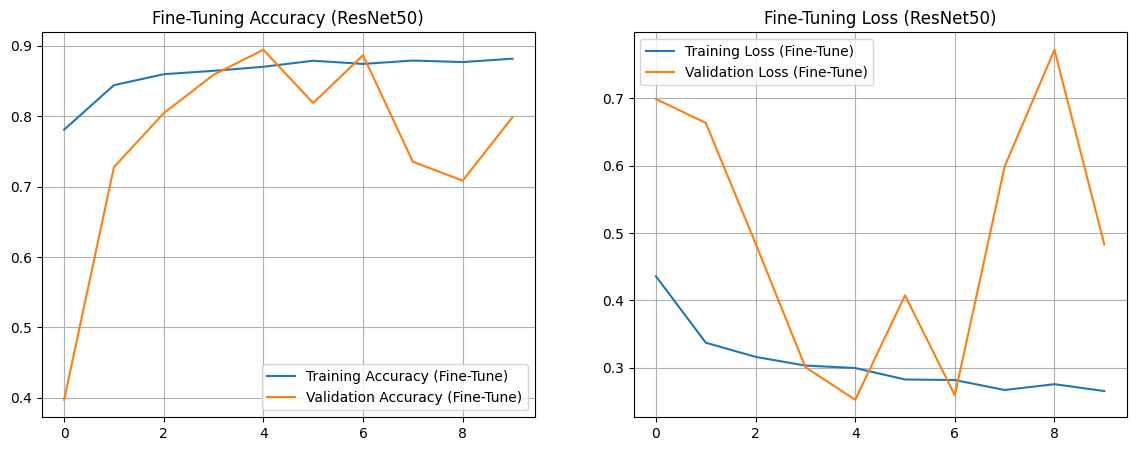


--- MENGEVALUASI MODEL RESNET50 (FINE-TUNED) PADA TEST SET ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 407ms/step - accuracy: 0.7815 - loss: 0.5245 - precision: 0.4558 - recall: 0.6257

Test Loss:     0.3689
Test Accuracy: 0.8558 (85.58%)
Test Precision: 0.8394 (83.94%)
Test Recall:   0.9513 (95.13%)

--- MODEL RESNET50 (FINE-TUNED) BERHASIL DISIMPAN SEBAGAI 'resnet50_finetuned_model.keras' ---
-rw-r--r-- 1 root root 159M Oct 20 08:24 resnet50_finetuned_model.keras


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Visualisasi Kurva Fine-Tuning ResNet50
# Kita akan ambil data dari objek 'history_resnet_finetune'
acc_ft = history_resnet_finetune.history['accuracy']
val_acc_ft = history_resnet_finetune.history['val_accuracy']
loss_ft = history_resnet_finetune.history['loss']
val_loss_ft = history_resnet_finetune.history['val_loss']

epochs_ran_ft = range(len(acc_ft))

plt.figure(figsize=(14, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_ran_ft, acc_ft, label='Training Accuracy (Fine-Tune)')
plt.plot(epochs_ran_ft, val_acc_ft, label='Validation Accuracy (Fine-Tune)')
plt.title('Fine-Tuning Accuracy (ResNet50)')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_ran_ft, loss_ft, label='Training Loss (Fine-Tune)')
plt.plot(epochs_ran_ft, val_loss_ft, label='Validation Loss (Fine-Tune)')
plt.title('Fine-Tuning Loss (ResNet50)')
plt.legend()
plt.grid(True)

plt.show()

# 2. Evaluasi Model ResNet50 (Fine-Tuned) pada Test Set
print("\n--- MENGEVALUASI MODEL RESNET50 (FINE-TUNED) PADA TEST SET ---")

# Model kita ada di 'model_resnet_weighted' (karena itu yg kita fine-tune)
# Bobotnya sudah otomatis di-restore ke Epoch 5
test_metrics_resnet = model_resnet_weighted.evaluate(test_generator_new, verbose=1)

print(f"\nTest Loss:     {test_metrics_resnet[0]:.4f}")
print(f"Test Accuracy: {test_metrics_resnet[1]:.4f} ({(test_metrics_resnet[1]*100):.2f}%)")
print(f"Test Precision: {test_metrics_resnet[2]:.4f} ({(test_metrics_resnet[2]*100):.2f}%)")
print(f"Test Recall:   {test_metrics_resnet[3]:.4f} ({(test_metrics_resnet[3]*100):.2f}%)")

# 3. Menyimpan Model (Gunakan format .keras yang baru!)
# Kita akan beri nama 'resnet50_finetuned_model.keras'
model_resnet_weighted.save('resnet50_finetuned_model.keras')

print("\n--- MODEL RESNET50 (FINE-TUNED) BERHASIL DISIMPAN SEBAGAI 'resnet50_finetuned_model.keras' ---")

# (Opsional) Verifikasi file sudah tersimpan
!ls -lh resnet50_finetuned_model.keras

**ANALISIS XAI**

Memuat model...
Model berhasil dimuat.
Berhasil memuat 624 label (seharusnya 624)
Membuat prediksi dengan MobileNetV2...
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 591ms/step
Membuat prediksi dengan ResNet50-FT...
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 467ms/step


--- LAPORAN KLASIFIKASI: MobileNetV2 (Recall: 92.05%) ---
               precision    recall  f1-score   support

   NORMAL (0)       0.84      0.72      0.78       234
PNEUMONIA (1)       0.84      0.92      0.88       390

     accuracy                           0.84       624
    macro avg       0.84      0.82      0.83       624
 weighted avg       0.84      0.84      0.84       624



--- LAPORAN KLASIFIKASI: ResNet50-FT (Recall: 95.13%) ---
               precision    recall  f1-score   support

   NORMAL (0)       0.90      0.70      0.78       234
PNEUMONIA (1)       0.84      0.95      0.89       390

     accuracy                           0.86       624
    macro avg       0.87      0.82      0.84       624
 weighted avg       0.86  

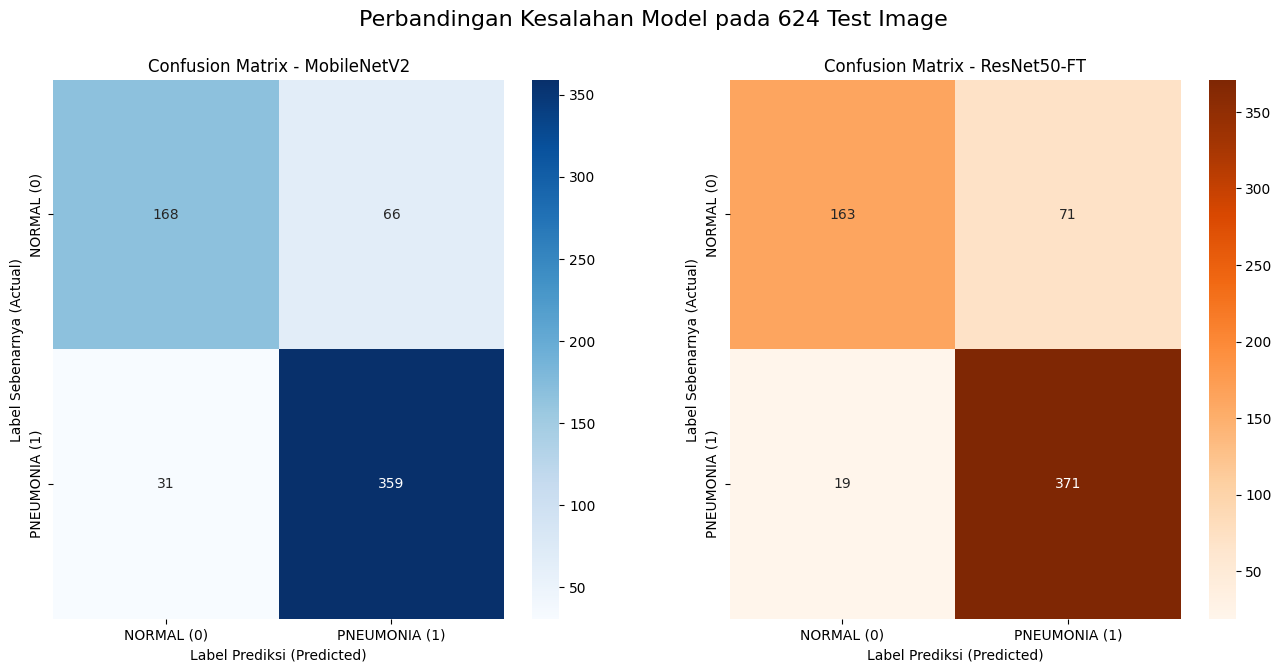

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 0. Muat kembali kedua model (dengan compile=False agar cepat)
print("Memuat model...")
model_mobilenet = keras.models.load_model('mobilenetv2_model.h5', compile=False)
model_resnet = keras.models.load_model('resnet50_finetuned_model.keras', compile=False)
print("Model berhasil dimuat.")

# 1. Dapatkan Label Sebenarnya (True Labels) dari Test Set
# Pastikan kita MENGGUNAKAN ULANG 'test_generator_new' dari Tahap 3
# Ini PENTING agar urutannya tidak ter-shuffle
# Kita perlu me-reset generator agar mulai dari awal
test_generator_new.reset()
true_labels = test_generator_new.classes
# Cek jumlahnya, harus 624
print(f"Berhasil memuat {len(true_labels)} label (seharusnya 624)")

# 2. Dapatkan Prediksi dari kedua model
print("Membuat prediksi dengan MobileNetV2...")
# Kita perlu me-reset lagi untuk model kedua
test_generator_new.reset()
pred_probs_mobilenet = model_mobilenet.predict(test_generator_new, verbose=1)

print("Membuat prediksi dengan ResNet50-FT...")
test_generator_new.reset()
pred_probs_resnet = model_resnet.predict(test_generator_new, verbose=1)

# 3. Konversi Probabilitas (misal 0.98) ke Label Biner (1)
# Threshold standar adalah 0.5
pred_labels_mobilenet = (pred_probs_mobilenet > 0.5).astype(int)
pred_labels_resnet = (pred_probs_resnet > 0.5).astype(int)

# 4. Buat Laporan!
target_names = ['NORMAL (0)', 'PNEUMONIA (1)']

print("\n\n--- LAPORAN KLASIFIKASI: MobileNetV2 (Recall: 92.05%) ---")
print(classification_report(true_labels, pred_labels_mobilenet, target_names=target_names))

print("\n\n--- LAPORAN KLASIFIKASI: ResNet50-FT (Recall: 95.13%) ---")
print(classification_report(true_labels, pred_labels_resnet, target_names=target_names))

# 5. Buat Confusion Matrix
cm_mobilenet = confusion_matrix(true_labels, pred_labels_mobilenet)
cm_resnet = confusion_matrix(true_labels, pred_labels_resnet)

# 6. Visualisasi Confusion Matrix (ini akan jadi gambar di paper Anda)
plt.figure(figsize=(16, 7))

plt.subplot(1, 2, 1)
sns.heatmap(cm_mobilenet, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - MobileNetV2')
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')

plt.subplot(1, 2, 2)
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - ResNet50-FT')
plt.ylabel('Label Sebenarnya (Actual)')
plt.xlabel('Label Prediksi (Predicted)')

plt.suptitle("Perbandingan Kesalahan Model pada 624 Test Image", fontsize=16)
plt.show()

**AFTERMATH**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1. Membuat folder baru di Google Drive Anda (aman jika sudah ada)
!mkdir -p "/content/drive/My Drive/Proyek_Pneumonia_SINTA2"

# 2. Menyalin file model Anda ke folder tersebut
print("Menyalin MobileNetV2...")
!cp mobilenetv2_model.h5 "/content/drive/My Drive/Proyek_Pneumonia_SINTA2/"

print("Menyalin ResNet50-FT...")
!cp resnet50_finetuned_model.keras "/content/drive/My Drive/Proyek_Pneumonia_SINTA2/"

# 3. Verifikasi (cek apakah file sudah ada di Drive)
print("\nVerifikasi file di Google Drive:")
!ls -lh "/content/drive/My Drive/Proyek_Pneumonia_SINTA2/"

Menyalin MobileNetV2...
Menyalin ResNet50-FT...

Verifikasi file di Google Drive:
total 168M
-rw------- 1 root root 9.0M Oct 20 09:25 mobilenetv2_model.h5
-rw------- 1 root root 159M Oct 20 09:25 resnet50_finetuned_model.keras


In [ ]:
import pandas as pd

# 1. Kumpulkan semua data yang telah kita temukan
data = {
    "Model": ["MobileNetV2", "EfficientNetB0", "ResNet50-FT"],

    "Method": ["Feature Extraction", "Feature Extraction / Weighted", "Fine-Tuning"],

    "Recall (Test)": ["92.05%", "N/A", "95.13%"],

    "Precision (Test)": ["84.47%", "N/A", "83.94%"],

    "Accuracy (Test)": ["84.46%", "N/A", "85.58%"],

    "Size": ["9.0 MB", "15.4 MB", "159 MB"],

    "Notes": [
        "Stabil, 17x lebih ringan, performa solid.",
        "Gagal total, tidak stabil, terjebak di local minima.",
        "Performa tertinggi, butuh metode canggih, ukuran sangat besar."
    ]
}

# 2. Buat DataFrame dari data
df_results = pd.DataFrame(data)

# 3. Simpan DataFrame ke file CSV
# index=False agar nomor baris (0, 1, 2) tidak ikut disimpan
df_results.to_csv('results.csv', index=False)

# 4. Tampilkan tabel di output Colab
print("--- RANGKUMAN HASIL PENELITIAN ---")
print(df_results)

# 5. Verifikasi file
print("\n\nFile 'results.csv' berhasil dibuat!")
!ls -lh results.csv

--- RANGKUMAN HASIL PENELITIAN ---
            Model                         Method Recall (Test)  \
0     MobileNetV2             Feature Extraction        92.05%   
1  EfficientNetB0  Feature Extraction / Weighted           N/A   
2     ResNet50-FT                    Fine-Tuning        95.13%   

  Precision (Test) Accuracy (Test)     Size  \
0           84.47%          84.46%   9.0 MB   
1              N/A             N/A  15.4 MB   
2           83.94%          85.58%   159 MB   

                                               Notes  
0          Stabil, 17x lebih ringan, performa solid.  
1  Gagal total, tidak stabil, terjebak di local m...  
2  Performa tertinggi, butuh metode canggih, ukur...  


File 'results.csv' berhasil dibuat!
-rw-r--r-- 1 root root 411 Oct 20 09:28 results.csv


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import time

# 0. Muat kembali kedua model (dengan compile=False agar cepat)
print("Memuat model...")
model_mobilenet = keras.models.load_model('mobilenetv2_model.h5', compile=False)
model_resnet = keras.models.load_model('resnet50_finetuned_model.keras', compile=False)
print("Model berhasil dimuat.")

# 1. Dapatkan Jumlah Parameter
params_mobilenet = model_mobilenet.count_params()
params_resnet = model_resnet.count_params()

# 2. Dapatkan Ukuran File (dalam MB)
size_mobilenet = os.path.getsize('mobilenetv2_model.h5') / (1024 * 1024) # Konversi Byte ke MB
size_resnet = os.path.getsize('resnet50_finetuned_model.keras') / (1024 * 1024)

# 3. Dapatkan Waktu Inferensi Rata-rata
# Kita akan mengukur waktu total untuk memprediksi SEMUA 624 gambar uji
# lalu mengambil rata-ratanya.

num_test_images = 624 # Kita tahu ini dari test_generator_new
# Pastikan test_generator_new sudah di-reset
test_generator_new.reset()

print(f"\n--- Mengukur Waktu Inferensi MobileNetV2 untuk {num_test_images} gambar ---")
start_time_m = time.time()
model_mobilenet.predict(test_generator_new, verbose=1)
end_time_m = time.time()

total_time_m = end_time_m - start_time_m
avg_time_m = (total_time_m / num_test_images) * 1000 # Konversi ke milidetik (ms)
print(f"Total Waktu MobileNetV2: {total_time_m:.2f} detik")
print(f"Rata-rata Waktu per Gambar: {avg_time_m:.2f} ms")


print(f"\n--- Mengukur Waktu Inferensi ResNet50-FT untuk {num_test_images} gambar ---")
test_generator_new.reset() # Reset lagi!
start_time_r = time.time()
model_resnet.predict(test_generator_new, verbose=1)
end_time_r = time.time()

total_time_r = end_time_r - start_time_r
avg_time_r = (total_time_r / num_test_images) * 1000 # Konversi ke milidetik (ms)
print(f"Total Waktu ResNet50-FT: {total_time_r:.2f} detik")
print(f"Rata-rata Waktu per Gambar: {avg_time_r:.2f} ms")


# 4. Buat DataFrame komprehensif yang baru
# Muat data 'results.csv' yang lama
df_results = pd.read_csv('results.csv')

# Tambahkan data baru
performance_data = {
    "Model": ["MobileNetV2", "EfficientNetB0", "ResNet50-FT"],
    "Total Parameters": [params_mobilenet, 4050852, params_resnet], # Ambil param EfficientNet dari summary lama
    "File Size (MB)": [size_mobilenet, 15.4, size_resnet],
    "Avg. Inference Time (ms)": [avg_time_m, "N/A (Failed)", avg_time_r]
}

df_performance = pd.DataFrame(performance_data)

# Gabungkan kedua DataFrame
df_final = pd.merge(df_results, df_performance, on="Model")

# 5. Tampilkan dan Simpan CSV Final
print("\n\n--- TABEL HASIL AKHIR (KOMPREHENSIF) ---")
# Atur format angka float agar mudah dibaca
pd.set_option('display.float_format', lambda x: '%.2f' % x)
print(df_final)

df_final.to_csv('results_final_comprehensive.csv', index=False)
print("\n\nFile 'results_final_comprehensive.csv' berhasil dibuat!")

Memuat model...
Model berhasil dimuat.

--- Mengukur Waktu Inferensi MobileNetV2 untuk 624 gambar ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 440ms/step
Total Waktu MobileNetV2: 14.13 detik
Rata-rata Waktu per Gambar: 22.64 ms

--- Mengukur Waktu Inferensi ResNet50-FT untuk 624 gambar ---
20/20 ━━━━━━━━━━━━━━━━━━━━ 13s 439ms/step
Total Waktu ResNet50-FT: 13.59 detik
Rata-rata Waktu per Gambar: 21.77 ms


--- TABEL HASIL AKHIR (KOMPREHENSIF) ---
            Model                         Method Recall (Test)  \
0     MobileNetV2             Feature Extraction        92.05%   
1  EfficientNetB0  Feature Extraction / Weighted           NaN   
2     ResNet50-FT                    Fine-Tuning        95.13%   

  Precision (Test) Accuracy (Test)     Size  \
0           84.47%          84.46%   9.0 MB   
1              NaN             NaN  15.4 MB   
2           83.94%          85.58%   159 MB   

                                               Notes  Total Parameters  \
0          Stabil, 17x lebih rin

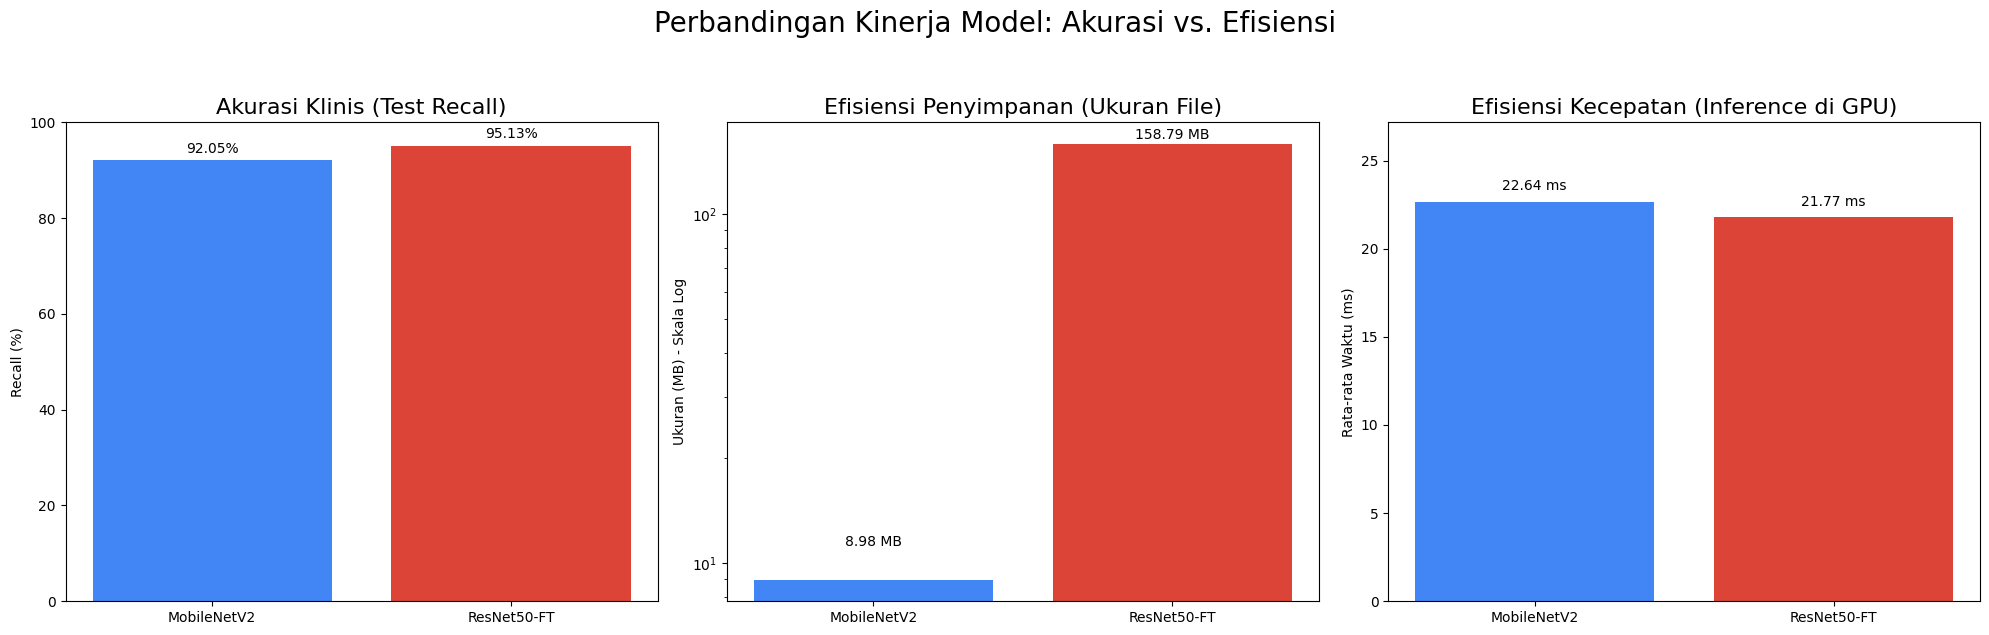

Grafik perbandingan berhasil disimpan sebagai 'comparison_charts.png'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Muat file CSV komprehensif yang kita buat
try:
    df_final = pd.read_csv('results_final_comprehensive.csv')
except FileNotFoundError:
    print("File 'results_final_comprehensive.csv' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan Tahap 14.")

# 2. Bersihkan data untuk plotting
# Kita hanya ingin membandingkan 2 model yang berhasil
df_plot = df_final[df_final['Model'].isin(['MobileNetV2', 'ResNet50-FT'])].copy()

# Konversi kolom persentase (string) ke angka (float)
# Kita hapus '%' dan konversi ke float
df_plot['Recall (Test)'] = df_plot['Recall (Test)'].str.replace('%', '').astype(float)

# Konversi kolom waktu ke float
df_plot['Avg. Inference Time (ms)'] = df_plot['Avg. Inference Time (ms)'].astype(float)

# 3. Buat 3 subplot (1 baris, 3 kolom)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Perbandingan Kinerja Model: Akurasi vs. Efisiensi', fontsize=20, y=1.05)

colors = ['#4285F4', '#DB4437'] # Biru Google, Merah Google

# --- Plot 1: Test Recall (Akurasi) ---
bars1 = ax1.bar(df_plot['Model'], df_plot['Recall (Test)'], color=colors)
ax1.set_title('Akurasi Klinis (Test Recall)', fontsize=16)
ax1.set_ylabel('Recall (%)')
ax1.set_ylim(0, 100) # Set Y-axis dari 0 sampai 100

# Tambahkan label angka di atas bar
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 1, f'{yval:.2f}%',
             ha='center', va='bottom')

# --- Plot 2: Ukuran File (Storage) ---
bars2 = ax2.bar(df_plot['Model'], df_plot['File Size (MB)'], color=colors)
ax2.set_title('Efisiensi Penyimpanan (Ukuran File)', fontsize=16)
ax2.set_ylabel('Ukuran (MB)')
# Set skala logaritmik agar perbedaan 9 MB vs 159 MB terlihat jelas
ax2.set_yscale('log')
ax2.set_ylabel('Ukuran (MB) - Skala Log')

# Tambahkan label angka di atas bar
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2.0, yval + 2, f'{yval:.2f} MB',
             ha='center', va='bottom')


# --- Plot 3: Waktu Inferensi (Kecepatan di GPU) ---
bars3 = ax3.bar(df_plot['Model'], df_plot['Avg. Inference Time (ms)'], color=colors)
ax3.set_title('Efisiensi Kecepatan (Inference di GPU)', fontsize=16)
ax3.set_ylabel('Rata-rata Waktu (ms)')
ax3.set_ylim(0, max(df_plot['Avg. Inference Time (ms)']) * 1.2) # Beri ruang di atas

# Tambahkan label angka di atas bar
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5, f'{yval:.2f} ms',
             ha='center', va='bottom')

# Tampilkan plot
plt.tight_layout()
plt.show()

# (Opsional) Simpan gambar plot ke file
fig.savefig('comparison_charts.png', bbox_inches='tight')
print("Grafik perbandingan berhasil disimpan sebagai 'comparison_charts.png'")

In [ ]:
import os

# 1. Mendefinisikan file dan folder yang akan di-zip
# (Ini adalah semua aset yang telah kita buat)
files_to_zip = [
    'chest_xray',                          # Folder dataset (2.29 GB)
    'mobilenetv2_model.h5',                # Model 1
    'resnet50_finetuned_model.keras',      # Model 2
    'results.csv',                         # CSV hasil awal
    'results_final_comprehensive.csv',     # CSV hasil akhir (lengkap)
    'comparison_charts.png',               # Plot perbandingan
    'kaggle.json'                          # Token Kaggle Anda
]

# 2. Membuat nama file zip
zip_filename = 'proyek_pneumonia_backup.zip'

# 3. Membuat perintah 'zip'
# -r untuk 'recursive' (agar folder 'chest_xray' ikut ter-zip)
# -q untuk 'quiet' (agar output tidak memenuhi layar)
command = f"zip -r -q {zip_filename}"

# Tambahkan setiap file/folder ke perintah
for item in files_to_zip:
    if os.path.exists(item): # Hanya zip jika filenya ada
        command += f" {item}"
    else:
        print(f"Peringatan: File '{item}' tidak ditemukan, akan dilewati.")

# 4. Eksekusi perintah
print(f"Memulai proses zip... Ini akan memakan waktu BEBERAPA MENIT (bisa 5-10 menit) karena datasetnya besar...")
!{command}

# 5. Verifikasi hasil
print("\nProses ZIP Selesai!")
print("Verifikasi file zip (menampilkan ukuran):")
!ls -lh {zip_filename}

Memulai proses zip... Ini akan memakan waktu BEBERAPA MENIT (bisa 5-10 menit) karena datasetnya besar...

Proses ZIP Selesai!
Verifikasi file zip (menampilkan ukuran):
-rw-r--r-- 1 root root 2.5G Oct 20 09:43 proyek_pneumonia_backup.zip
